In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import json
import pickle


#HELPER FUNCTIONS
def nanalysis(df):
    a=df.isnull().sum().sum()
    b=len(df)
    cost = round((a/b)*100,2)
    
    print("There are Rows with NaN: ", df.isnull().values.any())  
    print("How many rows with NaN? ", df.isnull().sum().sum())
    print("Doing a blanket dropNA will cost you:",cost,"% of your rows")
    print("The rows with NaN are:\n\n", df[df.isna().any(axis=1)])
    print("The columns with NaN are:\n\n", df.isna().any())


def dummify(X,cat):
    dummyCopy = X.copy()
    for elem in cat:        
        dummyCopy = dummyCopy.join(pd.get_dummies( dummyCopy[elem], prefix = str(elem), drop_first=True))
        dummyCopy.drop([elem], axis=1, inplace=True)
    
    return dummyCopy

def trimFatX(df,model):
    modelParams = pd.DataFrame(model.params.index.values)
    modelParams.rename(columns={0:'col'}, inplace=True)
    modelParams['p']=np.array(model.pvalues)
    toKeep = modelParams[modelParams["p"] <=0.05]
    keeplist = toKeep['col'].values
    kl=[keeplist[i] for i in range(0,len(keeplist))]
    if kl[0] == 'const':
        const = kl.pop(0)
    trimmedX = df[kl]
    return trimmedX



def fillDates(df):
    pattern = r'^\d{4}\.\d{2}\.\d{2}$'
    
    for index, row in df.iterrows():
        if re.match(pattern, str(row['Case Number'])) and pd.isna(row['Date']):
            df.at[index,'Date'] = row['Case Number']
    return df

def dropNaN(col,df):
    df = df.dropna(subset=[col])
    return df

def fixWrongDateFormat(df):
    pattern = r'^\d{4}\.\d{2}\.\d{2}$'
    for index, row in df.iterrows():
        if re.match(pattern, str(row['Date'])):
            df.at[index, 'Date'] = row['Date'].replace('.', '-')
    return df
    
    
    
def sortedUniqueCounts(df, column_name):   
    value_counts = df[column_name].value_counts()
    value_counts_dict = dict(value_counts)
    value_counts_dict_sorted = {k: v for k, v in sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True)}

    return value_counts_dict_sorted


def cleanY(df):
    for index, row in df.iterrows():
        if row['Fatal'] in ["UNKNOWN", "F", "y"]:
            df.at[index,'Fatal'] = "Y"
        elif row['Fatal'] in ["n","2017.0", "Y x 2", "Nq"]:
            df.at[index, 'Fatal'] = "N"
    return df

def extract_sharks(x, sharks):
    if isinstance(x, str):
        x = x.lower()
        shark_list = []
        for shark in sharks:
            shark = shark.lower()
            if shark in x:
                shark_list.append(shark.lower().strip())

        if len(shark_list) > 0:
            return ', '.join(shark_list)
        else:
            return 'Unknown'
    else:
        return 'Unknown'

def classifyMyShark(df, col, targetcol, sharks):
    pattern = '|'.join(sharks)
    df[targetcol] = df[col].astype(str).str.findall(pattern, flags=re.IGNORECASE).apply(', '.join)
    df[targetcol].replace('', 'Unknown', inplace=True)
    #df[targetcol].replace(to_replace=r'(Juvenile )?(.*white.*)', value=r'White \2', regex=True, inplace=True)
    df.dropna(subset=[targetcol], inplace=True)
    df.sort_values(by=[targetcol], inplace=True)
    return df


def consolidate(myset, mydict):
    #first make a new dict
    conDict = {key: 0 for key in myset}
    #now transfer the values
    for key in mydict.keys():
        if "," in key:
            newkeys = key.split(',')
            for elem in newkeys:
                conDict[elem.strip()]+=mydict[key]
        else:
            conDict[key] += mydict[key]
            
    sortedDict = dict(sorted(conDict.items(), key=lambda item: item[1], reverse = True))
    conDict.clear()
    conDict.update(sortedDict)
    return conDict



def barFromDict(dictionary, excludekeys = []):
    
    new_dict = {k: v for k, v in dictionary.items() if k not in excludekeys}
    keys = list(new_dict.keys())
    values = list(new_dict.values())
    
    sns.set_style("whitegrid")
    
    ax = sns.barplot(x=keys, y=values, palette=sns.color_palette("muted"))
    
    # Add value annotations to the bars
    for i, v in enumerate(values):
        ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')

    
    ax.set(xlabel='Shark Species', ylabel='Attack Counts so far ')
    ax.set_xticklabels(keys, rotation=90)
    plt.show()


def probabilityDF(dict1,dict2):
    myKeys = list(dict2.keys())
    fatalist = []
    attacklist = []
    for key in myKeys:
        fatalist.append(dict2[key])
    
    for key in myKeys:
        attacklist.append(dict1[key])
    
    df = pd.DataFrame({'SharkSpecies': myKeys,
                       'Attacks': attacklist,
                       'Fatalities': fatalist})
    
    
    # do not want the unkown or unidentified attacks to skew my results so i remove them from the counts
    
    df= df.drop(df[df['SharkSpecies'] == 'unknown'].index)
    totalAttacks = df.Attacks.sum()
    df['AttackProbability']=df['Attacks']/totalAttacks
    df['FatalityRatio'] = df['Fatalities']/df['Attacks']
    df['FatalityProbability'] =  df['AttackProbability'] * df['FatalityRatio']
    
    
    return df

    
    
def overlayBar(dict1, dict2):
    # Create a Pandas DataFrame from the two dictionaries
    
    ##Making sure Order is right!
    myKeys = list(dict2.keys())
    fatalist = []
    attacklist = []
    for key in myKeys:
        fatalist.append(dict2[key])
    
    for key in myKeys:
        attacklist.append(dict1[key])
    
    
    df = pd.DataFrame({'SharkSpecies': myKeys,
                       'Attacks': attacklist,
                       'Fatalities': fatalist})
    

    df1= df.drop(df[df['SharkSpecies'] == 'unknown'].index)
    
    # Melt the DataFrame to stack the values
    df_melted = pd.melt(df1, id_vars='SharkSpecies', var_name='AttackType', value_name='Value')

    # Create a custom color palette
    colors = sns.color_palette(['orange', 'red'])
    
    # Create a bar chart using Seaborn
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='SharkSpecies', y='Value', hue='AttackType', data=df_melted, palette=colors)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.xlabel('Shark Species', fontsize=14)
    plt.ylabel('Number of Attacks', fontsize=14)
    plt.legend(title='Attack Type', title_fontsize=12, fontsize=10)
    
    # Add annotations to each bar with font properties
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', labels=i.datavalues.astype(int), color='grey')
    
    plt.show()
    
    

    
def identifiedvsunidentified(dictionary):
    mySet = {"Identified Sharks", "Unidentified Sharks"}
    pairDict = {key: 0 for key in mySet}
    for key in dictionary.keys():
        if key == "unknown":
            pairDict['Unidentified Sharks'] = dictionary['unknown']
        else:
            pairDict['Identified Sharks'] += dictionary[key]
    
    return pairDict
    
    

def pieFromDict(dictionary, excludekeys=[]):
    
    new_dict = {k: v for k, v in dictionary.items() if k not in excludekeys}
    
    labels = list(new_dict.keys())
    sizes = list(new_dict.values())

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.legend(labels, bbox_to_anchor=(1.6, 1.0))
    plt.show()
    
    
    
def saveMyDictionary(dictionary, name):    
    filename = str(name) + ".pkl"
    with open(filename, 'wb') as fp:
        pickle.dump(dictionary, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print("file:", filename, "succesfully created.")
    
    
def loadMyDictionary(filename):
    with open(filename, 'rb') as fp:
        loaded_dict = pickle.load(fp)
    return loaded_dict


In [426]:
dfAttacks = pd.read_csv("C:\\Users\\anshu\\Desktop\\mySharks\\global-shark-attack.csv", sep=';')

In [427]:
dfAttacks.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,2023.03.05,2023-03-05,2023.0,Unprovoked,BRAZIL,Pernambuco,Piedade Beach,Swimming,male,M,...,N,NaN,NaN,"JC, 3/6/2023",NaN,NaN,NaN,NaN,NaN,NaN
1,2023.03.02,2023-03-02,2023.0,Unprovoked,SEYCHELLES,Praslin Island,NaN,Snorkeling,Arthur …,M,...,UNKNOWN,Afternoon,Lemon shark,"Midlibre, 3/18/2023",NaN,NaN,NaN,NaN,NaN,NaN
2,2022.12.07,2022-11-04,2022.0,Unprovoked,USA,California,"Del Mar Beach, San Diego County",Swimming,Lyn Jutronich,F,...,N,10h00,Juvenile white shark,"R.Collier, GSAF",NaN,NaN,NaN,NaN,NaN,NaN
3,2021.07.27.b,2021-07-26,2021.0,Unprovoked,USA,New York,"Jones Beach, Nassau County",Swimming,male,M,...,N,11h00,A small shark,"S. Curatolo-Wagemann, GSAF & K. McMurray, Trac...","2021.07.26-JonesBeach, pdf",http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2021.07.26,2021.07.26,6691.0
4,2021.04.19,2021-04-14,2021.0,Unprovoked,SOUTH AFRICA,KwaZulu-Natal,Mdloti,Spearfishing,Jarid Norman,M,...,N,Afternoon,1.3m shark,"M. Michelson, GSAFand K. McMurray, TrackingSha...",2021.04.14-Norman.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2021.04.14,2021.04.14,6647.0


In [428]:
print(dfAttacks.columns)

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')


In [429]:
dropcols =  ['Investigator or Source', 'pdf', 'href formula', 'href','Case Number.1', 'Case Number.2', 'original order']
dfAttacks.drop(columns=dropcols, inplace=True)

In [430]:
dfAttacks

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
0,2023.03.05,2023-03-05,2023.0,Unprovoked,BRAZIL,Pernambuco,Piedade Beach,Swimming,male,M,14,Right thigh bitten resulting in surgical amput...,N,NaN,NaN
1,2023.03.02,2023-03-02,2023.0,Unprovoked,SEYCHELLES,Praslin Island,NaN,Snorkeling,Arthur …,M,6,Left foot bitten,UNKNOWN,Afternoon,Lemon shark
2,2022.12.07,2022-11-04,2022.0,Unprovoked,USA,California,"Del Mar Beach, San Diego County",Swimming,Lyn Jutronich,F,50,Shallow punctures & lacerations to right thigh,N,10h00,Juvenile white shark
3,2021.07.27.b,2021-07-26,2021.0,Unprovoked,USA,New York,"Jones Beach, Nassau County",Swimming,male,M,NaN,Minor injury to calf,N,11h00,A small shark
4,2021.04.19,2021-04-14,2021.0,Unprovoked,SOUTH AFRICA,KwaZulu-Natal,Mdloti,Spearfishing,Jarid Norman,M,38.0,Minor injury to head,N,Afternoon,1.3m shark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,1500.00.00,NaN,1977.0,Unprovoked,NaN,Ionian Sea,NaN,Sponge diving,males,M,NaN,FATAL,Y,NaN,NaN
6836,ND-0154,NaN,NaN,Unprovoked,KENYA,Mombasa,Kilindini,Diving,Hamisi Njenga,M,NaN,FATAL,Y,NaN,NaN
6837,ND-0150,NaN,NaN,Unprovoked,USA,South Carolina,Charleston,Swimming,Rick Donnis,M,NaN,Minor injury,N,NaN,NaN
6838,ND-0111,NaN,NaN,Unprovoked,USA,Florida,"Tampa Bay, Hillsborough County",Wade-fishing,Ed Snyder,M,NaN,"No injury, shark rammed his back",N,NaN,NaN


In [431]:
##Lets Work on the dates and make them into a timeseries


In [432]:
print (len(dfAttacks))

6840


In [433]:
dfAttacks.loc[dfAttacks.Date.isna()]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
69,2008.07.09,NaN,2008.0,Watercraft,UNITED KINGDOM,Sussex,"Rock-a-Nore, Hastings",Rowing an inflatable dinghy,Occupants: Luke Jones & James Sequin,M,16,Shark leapt into & damaged the dinghy but no i...,N,NaN,"Starry smoothhound shark, 1m"
129,1980.07.23,NaN,1980.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Tom Durrance,M,NaN,Lower leg bitten,N,NaN,NaN
162,1960.00.00.d,NaN,1960.0,Unprovoked,MOZAMBIQUE,Gaza,Xai Xai,Swimming,Miss Fillardo,F,5,FATAL,Y,NaN,NaN
183,1944.01.14,NaN,1944.0,Sea Disaster,SOUTH PACIFIC OCEAN,NaN,NaN,Adrift on raft,"Unknown, he was Nabetari's companion",M,NaN,FATAL Arm severed,Y,NaN,NaN
206,1919.01.09,NaN,1919.0,Watercraft,ITALY,NaN,Savona,Fishing,NaN,M,NaN,No injury,N,NaN,13' shark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,1500.00.00,NaN,1977.0,Unprovoked,NaN,Ionian Sea,NaN,Sponge diving,males,M,NaN,FATAL,Y,NaN,NaN
6836,ND-0154,NaN,NaN,Unprovoked,KENYA,Mombasa,Kilindini,Diving,Hamisi Njenga,M,NaN,FATAL,Y,NaN,NaN
6837,ND-0150,NaN,NaN,Unprovoked,USA,South Carolina,Charleston,Swimming,Rick Donnis,M,NaN,Minor injury,N,NaN,NaN
6838,ND-0111,NaN,NaN,Unprovoked,USA,Florida,"Tampa Bay, Hillsborough County",Wade-fishing,Ed Snyder,M,NaN,"No injury, shark rammed his back",N,NaN,NaN


In [434]:
dfAttacks = fillDates(dfAttacks)

In [435]:
dfAttacks.loc[dfAttacks.Date.isna()]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
162,1960.00.00.d,NaN,1960.0,Unprovoked,MOZAMBIQUE,Gaza,Xai Xai,Swimming,Miss Fillardo,F,5,FATAL,Y,NaN,NaN
218,1883.10.20.R,NaN,1883.0,Unprovoked,AUSTRALIA,Tasmania,Between Port Arthur Penal Colony & Forestier P...,Swimming / escaping imprisonment,Owen,M,NaN,FATAL,Y,NaN,NaN
232,ND.0060,NaN,NaN,Unprovoked,FIJI,Kadavu Island Group,"18.8S, 178.25E",Swimming with fish attached to belt,Fijian girl,F,NaN,Severely injured when fish were seized by shark,N,NaN,NaN
233,ND.0046,NaN,NaN,Unprovoked,SOLOMON ISLANDS,New Georgia,"Munda Island, Roviana Lagoon",Floating on his back,American male,M,NaN,Buttock bitten,N,NaN,NaN
234,ND.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,1853.00.00.c,NaN,1853.0,Unprovoked,USA,Florida,"Near Fernandina Bar, Nassau County",Knocked overboard,Captain George Jacob Hanscheldt,M,NaN,FATAL,Y,NaN,NaN
6836,ND-0154,NaN,NaN,Unprovoked,KENYA,Mombasa,Kilindini,Diving,Hamisi Njenga,M,NaN,FATAL,Y,NaN,NaN
6837,ND-0150,NaN,NaN,Unprovoked,USA,South Carolina,Charleston,Swimming,Rick Donnis,M,NaN,Minor injury,N,NaN,NaN
6838,ND-0111,NaN,NaN,Unprovoked,USA,Florida,"Tampa Bay, Hillsborough County",Wade-fishing,Ed Snyder,M,NaN,"No injury, shark rammed his back",N,NaN,NaN


In [436]:
#I can drop the rest of the 215 columns
dfAttacks = dropNaN('Date', dfAttacks)

In [437]:
dfAttacks.loc[dfAttacks.Date.isna()]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species


In [438]:
#We need to convert date column to datetime in order to have it eventually be the index of a time series
#First we replace the dots with -
dfAttacks = fixWrongDateFormat(dfAttacks)

In [439]:
#get all rows where datepattern is not consistent with yyyy/mm/dd
pattern = r'^\d{4}-\d{2}-\d{2}$'
mask = ~dfAttacks['Date'].str.contains(pattern)
dfAttacks[mask]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
642,1944.09.00,144-07-22,1944.0,Unprovoked,SOUTH AFRICA,Western Cape Province,Hartenbos,Swimming,Albert Schmidt,M,17.0,"FATAL, body not recovered",Y,16h30,"White shark, according to witnesses"
6601,2020.07.13,202-07-10,2020.0,Unprovoked,USA,Florida,"Cocoa Beach, Brevard County",Surfing,Jaedyn Wagner,F,15.0,Minor injury to right foot,N,08h00,NaN


In [440]:
#Fix these Dates
dfAttacks.at[642,'Date']='1944-09-01'
dfAttacks.at[6601,'Date']='2020-07-13'
dfAttacks.at[6835,'Date']='1977-07-07'

In [441]:
pattern = r'^\d{4}-\d{2}-\d{2}$'
mask = ~dfAttacks['Date'].str.contains(pattern)
dfAttacks[mask]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species


In [442]:
# Convert the 'Date' column to datetime objects with format yyyy-mm-dd
dfAttacks['Date'] = pd.to_datetime(dfAttacks['Date'], format='%Y-%m-%d', errors='coerce')



C:\Users\anshu\AppData\Local\Temp\ipykernel_9272\1760441188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfAttacks['Date'] = pd.to_datetime(dfAttacks['Date'], format='%Y-%m-%d', errors='coerce')


In [443]:
dfAttacks.loc[dfAttacks.Date.isna()]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
692,1543.00.00,NaT,1500.0,Unprovoked,MEXICO,NaN,NaN,NaN,male,M,NaN,Foot severed,N,NaN,NaN
1163,1721.06.00,NaT,1700.0,Unprovoked,FRANCE,NaN,Nice,NaN,child,M,NaN,FATAL,Y,NaN,NaN
1164,1700.00.00.a,NaT,1638.0,Unprovoked,NaN,NaN,NaN,NaN,sailors,M,NaN,NaN,UNKNOWN,NaN,NaN
1571,1959.01.00,NaT,1959.0,Unprovoked,INDIA,Orissa,Mouth of Devi River at Machgaon,NaN,NaN,NaN,NaN,"5 people killed by sharks, 30 others injured",Y,NaN,1.5 m to 1.8 m [5' to 6'] sharks
1888,1887.00.00,NaT,1886.0,Provoked,USA,New Jersey,"Sandy Hook Bay, Highlands, Monmouth County","Netting menhaden, sharks caught in net",Boat of Captain Forman White,NaN,NaN,"No injury, sharks ripped net & bit boat PROVOK...",N,NaN,NaN
1907,1637.00.00.R,NaT,1642.0,Unprovoked,USA,New York,Between Manhattan and The Bronx,Swimming,Antony Van Corlear,M,NaN,FATAL,Y,NaN,NaN
3129,2018.06.03.b,NaT,2018.0,Unprovoked,EGYPT,NaN,Brothers Island,Scuba Diving,Alexander Kraenkl,M,NaN,Laceration to right thigh,N,NaN,Oceanic whitetip shark
3317,1902.06.00,NaT,1902.0,Provoked,NEW ZEALAND,North Island,Poverty Bay,Standing on ship deck,male,M,NaN,"No injury, hooked shark bit tousers. PROVOKED ...",N,NaN,NaN
3341,1827.00.00,NaT,1826.0,Unprovoked,GHANA,Cape Coast,NaN,Bathing,a seaman from HM Redwing,M,NaN,FATAL,Y,NaN,NaN
4325,1554.00.00,NaT,1518.0,Unprovoked,MEXICO,Yucatan,Cozumel,Swmming,A cacique (a chief),M,NaN,Toes severed,N,NaN,NaN


In [444]:
dfAttacks = dropNaN('Date', dfAttacks)

In [445]:
dfAttacks.loc[dfAttacks.Date.isna()]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species


In [446]:
print (len(dfAttacks))

6604


In [447]:
print(dfAttacks.columns)

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species '],
      dtype='object')


In [448]:
new_column_names = {'Case Number': 'CaseNumber', 'Species ': 'Species', 'Fatal (Y/N)': 'Fatal'}
dfAttacks = dfAttacks.rename(columns=new_column_names)

In [449]:
dfAttacks['Species'].nunique()

1522

In [450]:
print(dfAttacks['Fatal'].unique())

['N' 'UNKNOWN' 'Y' 'F' 'y' 'n' '2017.0' 'Y x 2' 'Nq']


In [451]:
## We need to fix this Y because we will need it for our regression later
#First I need to count the number of unknowns -- I will make a function that will always provide me the valuecounts of a column, 
#sorted in a dictionary



In [452]:
#In this case I will set unknowns to Y because if it is not known if a person is dead or not, i assume the person is dead
#The rest I will set to N
dfAttacks = cleanY(dfAttacks)


In [453]:
fatalDict = sortedUniqueCounts(dfAttacks, 'Fatal')

In [454]:
print(fatalDict)

{'N': 4635, 'Y': 1969}


In [455]:
SharksDict = sortedUniqueCounts(dfAttacks, 'Species')

In [456]:
print(SharksDict)

{'White shark': 186, 'Shark involvement prior to death was not confirmed': 104, 'Invalid': 101, 'Shark involvement not confirmed': 92, 'Tiger shark': 84, 'Shark involvement prior to death unconfirmed': 67, 'Bull shark': 63, "6' shark": 42, "4' shark": 42, "1.8 m [6'] shark": 35, 'Questionable incident': 34, 'Questionable': 32, "1.5 m [5'] shark": 30, "5' shark": 29, 'Wobbegong shark': 27, "4' to 5' shark": 27, '2 m shark': 26, "1.2 m [4'] shark": 26, "3' shark": 26, 'a small shark': 23, 'Blacktip shark': 23, "3 m [10'] shark": 22, 'No shark involvement': 21, 'Nurse shark': 20, "3' to 4' shark": 19, '3 m shark': 17, "3.7 m [12'] shark": 16, "2.4 m [8'] shark": 16, "12' shark": 16, "7' shark": 14, 'Blue shark': 14, "1.2 m to 1.5 m [4' to 5'] shark": 14, 'Raggedtooth shark': 14, 'Mako shark': 14, 'small shark': 13, 'Bronze whaler shark': 13, 'Shark involvement prior to death not confirmed': 13, '1.5 m shark': 13, "6 m [20'] white shark": 12, "5 m [16.5'] white shark": 12, "10' shark": 12,

In [457]:
sharks = ['White shark','Tiger', 'Bull', 'Oceanic Whitetip','Oceaniic', 'Hammerhead', 'Blacktip', 'Sand Tiger', 'Lemon', 'Blue', 'Mako', 'Bronze Whaler', 'Galapagos', 'Silky', 'Dusky', 'Grey Nurse', 'Goblin', 'Sandbar', 'Nurse', 'Sevengill', 'Wobbegong', 'Thresher', 'Blacktip Reef', 'Grey reef','Whitetip Reef','Spinner','Zambezi','Porbeagle','Raggedtooth']

In [458]:

dfAttacks = classifyMyShark(dfAttacks, 'Species','SharkSpecies', sharks)


In [459]:
dfAttacks.loc[dfAttacks.SharkSpecies.str.contains("Oceaniic")]

,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,SharkSpecies
3349,2022.07.01.c,2022-07-01,2022.0,Unprovoked,EGYPT,"Hurghada, Red Sea Governorate",Sahl Hasheesh,Swimming,Elisabeth Sauer,F,68.0,FATAL,Y,NaN,"Oceaniic whitetip shark/tiger shark, 2m shark","Oceaniic, tiger"
928,2022.07.03.a,2022-07-01,2022.0,Unprovoked,EGYPT,"Hurghada, Red Sea Governorate",Sahl Hasheesh,Snorkeling,Roxana Donisan,F,40s,FATAL,Y,NaN,Oceaniic whitetip shark/tiger shark,"Oceaniic, tiger"


In [460]:
print(dfAttacks[dfAttacks['SharkSpecies'] == "Unknown"].index)

Int64Index([4541, 4546, 4554, 4566, 4557, 4556, 3468, 4565, 4553, 4555,
            ...
            2082, 2419, 2420, 2099, 2078, 2424, 2080, 2086, 2098, 2079],
           dtype='int64', length=4676)


In [461]:
print(len(dfAttacks))

6604


In [462]:
dfAttacks = dfAttacks.sort_values('Date', ascending=False)

In [463]:
SharksDict = sortedUniqueCounts(dfAttacks, 'SharkSpecies')

In [464]:
print(len(SharksDict))

92


In [465]:
dfAttacks.loc[dfAttacks.SharkSpecies.str.contains('white shark, white shark')]

,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,SharkSpecies


In [466]:
dfAttacks.loc[dfAttacks.SharkSpecies == 'bull, bull', 'SharkSpecies'] = 'bull'
dfAttacks.loc[dfAttacks.SharkSpecies == 'blue, blue', 'SharkSpecies'] = 'blue'
dfAttacks.loc[dfAttacks.SharkSpecies == 'white shark, white shark', 'SharkSpecies'] = 'white shark'
dfAttacks.loc[dfAttacks.SharkSpecies == 'dusky, dusky', 'SharkSpecies'] = 'dusky'
dfAttacks.loc[dfAttacks.SharkSpecies == 'grey reef, grey reef', 'SharkSpecies'] = 'grey reef'
dfAttacks.loc[dfAttacks.SharkSpecies == 'Oceaniic, tiger', 'SharkSpecies'] = 'oceanic whitetip'
dfAttacks.loc[dfAttacks.SharkSpecies == 'lemon, lemon', 'SharkSpecies'] = 'lemon'

In [467]:
dfAttacks['SharkSpecies'] = dfAttacks['SharkSpecies'].str.lower()
SharksDict = sortedUniqueCounts(dfAttacks, 'SharkSpecies')

In [468]:
print(SharksDict)

{'unknown': 4676, 'white shark': 668, 'tiger': 302, 'bull': 197, 'blacktip': 94, 'bronze whaler': 69, 'nurse': 67, 'mako': 55, 'wobbegong': 54, 'blue': 52, 'hammerhead': 46, 'raggedtooth': 43, 'lemon': 41, 'grey nurse': 38, 'oceanic whitetip': 28, 'blacktip, spinner': 27, 'spinner': 23, 'grey reef': 18, 'sevengill': 13, 'dusky': 12, 'galapagos': 7, 'bull, tiger': 7, 'porbeagle': 6, 'sandbar': 5, 'whitetip reef': 4, 'thresher': 4, 'silky': 4, 'spinner, blacktip': 3, 'zambezi': 3, 'white shark, bronze whaler': 3, 'dusky, blacktip': 2, 'goblin': 2, 'bull, lemon': 2, 'white shark, white shark': 2, 'white shark, blue': 1, 'lemon, tiger': 1, 'grey reef, grey reef': 1, 'dusky, dusky': 1, 'lemon, lemon': 1, 'blue, blue': 1, 'white shark, thresher': 1, 'thresher, blue': 1, 'oceanic whitetip, blue, tiger, bull': 1, 'mako, grey nurse': 1, 'white shark, sevengill': 1, 'blue, porbeagle': 1, 'porbeagle, white shark': 1, 'bull, sandbar, dusky': 1, 'lemon, bull': 1, 'white shark, oceanic whitetip': 1,

In [469]:
##Lets save our df here:
dfAttacks.to_csv("SharkWrangler1.csv", index=False)

In [470]:
dfKnown = dfAttacks.loc[dfAttacks.SharkSpecies != "unknown"]

In [471]:
dfKnown.to_csv("KnownSharks.csv", index=False)

In [472]:
mySharks = list(SharksDict.keys())

In [473]:
print(mySharks)

['unknown', 'white shark', 'tiger', 'bull', 'blacktip', 'bronze whaler', 'nurse', 'mako', 'wobbegong', 'blue', 'hammerhead', 'raggedtooth', 'lemon', 'grey nurse', 'oceanic whitetip', 'blacktip, spinner', 'spinner', 'grey reef', 'sevengill', 'dusky', 'galapagos', 'bull, tiger', 'porbeagle', 'sandbar', 'whitetip reef', 'thresher', 'silky', 'spinner, blacktip', 'zambezi', 'white shark, bronze whaler', 'dusky, blacktip', 'goblin', 'bull, lemon', 'white shark, white shark', 'white shark, blue', 'lemon, tiger', 'grey reef, grey reef', 'dusky, dusky', 'lemon, lemon', 'blue, blue', 'white shark, thresher', 'thresher, blue', 'oceanic whitetip, blue, tiger, bull', 'mako, grey nurse', 'white shark, sevengill', 'blue, porbeagle', 'porbeagle, white shark', 'bull, sandbar, dusky', 'lemon, bull', 'white shark, oceanic whitetip', 'tiger, hammerhead', 'oceanic whitetip, white shark', 'bronze whaler, tiger', 'tiger, bull', 'blacktip, sandbar', 'bronze whaler, grey nurse', 'sandbar, blacktip', 'bull, bul

In [474]:
sharkSet=set()
for shark in mySharks:
    if "," in shark:
        #print(shark)
        words = shark.split(',')
        #print(words)
        for word in words:
            sharkSet.add(word.strip())
            #print(sharkSet)
    else:
        sharkSet.add(shark.strip())
            
            

In [475]:
print(sharkSet)

{'lemon', 'grey reef', 'blacktip', 'unknown', 'tiger', 'porbeagle', 'bull', 'spinner', 'silky', 'sandbar', 'nurse', 'oceanic whitetip', 'mako', 'blue', 'sand tiger', 'white shark', 'bronze whaler', 'sevengill', 'zambezi', 'thresher', 'whitetip reef', 'hammerhead', 'wobbegong', 'grey nurse', 'goblin', 'dusky', 'galapagos', 'raggedtooth'}


In [476]:
newDict = consolidate(sharkSet,SharksDict) #Getting the indvidual counts of attacks of each shark
   

In [477]:
print(newDict)

{'unknown': 4676, 'white shark': 681, 'tiger': 314, 'bull': 213, 'blacktip': 128, 'bronze whaler': 74, 'nurse': 67, 'blue': 58, 'mako': 57, 'spinner': 54, 'wobbegong': 54, 'lemon': 47, 'hammerhead': 47, 'raggedtooth': 43, 'grey nurse': 40, 'oceanic whitetip': 31, 'grey reef': 20, 'dusky': 17, 'sevengill': 14, 'porbeagle': 9, 'sandbar': 8, 'galapagos': 7, 'thresher': 6, 'silky': 4, 'whitetip reef': 4, 'zambezi': 3, 'goblin': 2, 'sand tiger': 1}


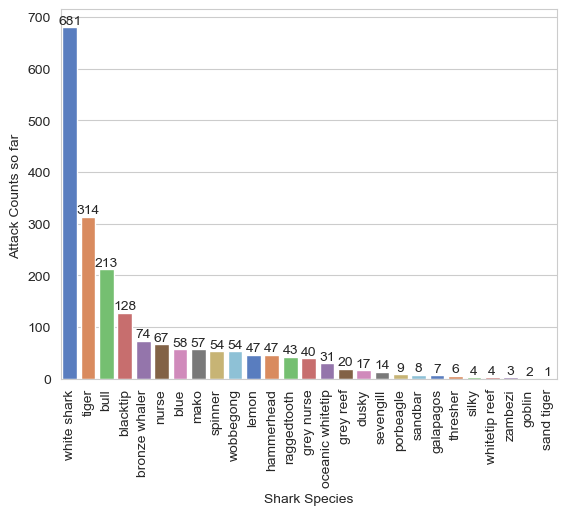

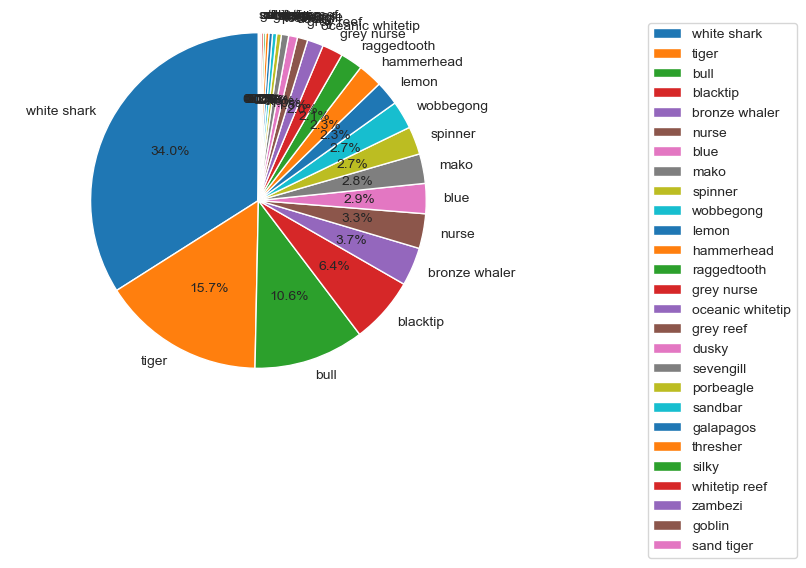

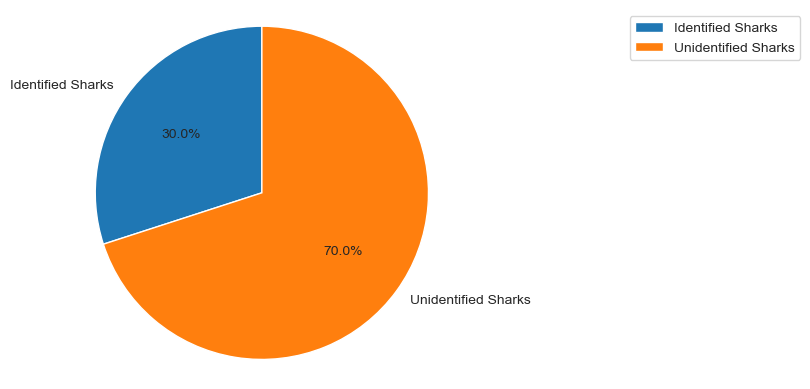

In [478]:
barFromDict(newDict, ['unknown'])
pieFromDict(newDict,['unknown'])
pieFromDict(identifiedvsunidentified(newDict))

adict=identifiedvsunidentified(newDict)

In [479]:
saveMyDictionary(newDict,"allSharkCounts")
saveDictionary(adict,"identifiedvsunidentified") 

file: allSharkCounts.pkl succesfully created.
file: identifiedvsunidentified.pkl succesfully created.


In [480]:
dfKnown = pd.read_csv("KnownSharks.csv")

In [481]:
dfAttacks.head(2)
#fatalDict = sortedUniqueCounts(dfAttacks, 'Fatal')

,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,SharkSpecies
2392,2023.03.19,2023-03-19,2023.0,Unprovoked,USA,Hawaii,Anaehoomalu Bay,Swimming,male,M,60,Left hand and left leg.,N,12h30,NaN,unknown
1652,2023.03.16,2023-03-16,2023.0,Unprovoked,AUSTRALIA,Western Australia,Cheynes Beach,Surf-sking,female,F,NaN,NaN,N,08h00,5m to 6m shark,unknown


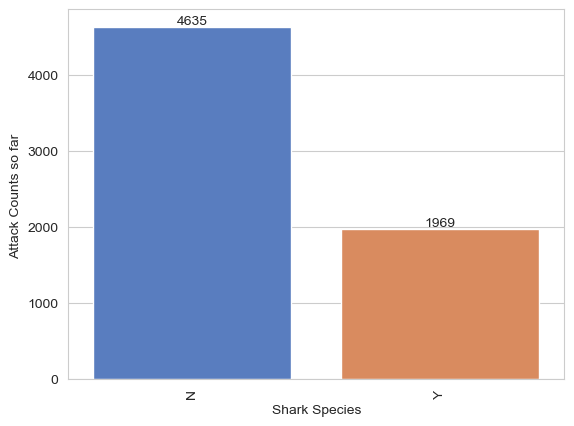

In [482]:
barFromDict(fatalDict)

In [483]:
##Lets make the Fatality DataFrame ;)

dfFatality = dfAttacks.loc[dfAttacks.Fatal == "Y"]
dfNONFatality = dfAttacks.loc[dfAttacks.Fatal == "N"]

In [484]:
dfFatality

,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,SharkSpecies
1,2023.03.02,2023-03-02,2023.0,Unprovoked,SEYCHELLES,Praslin Island,NaN,Snorkeling,Arthur …,M,6,Left foot bitten,Y,Afternoon,Lemon shark,lemon
3580,2023.02.21,2023-02-19,2023.0,Unprovoked,NEW CALEDONIA,South Province,"Château-Royal Beach , Noumea",Swimming,Chris Davis,M,59,"FATAL, Multiple injuries",Y,16h00,Bull shark,bull
696,2023.02.19.b,2023-02-18,2023.0,Questionable,ARGENTINA,Patagonia,Chubut Province,NaN,Diego Barría,M,32,Death by misadventure,Y,NaN,NaN,unknown
2163,2023.02.18,2023-02-04,2023.0,Unprovoked,AUSTRALIA,Western Australia,Freemantle,Swimming,Stella Berry,F,16,Fatal,Y,15h30,Bull shark,bull
4078,2023.01.20,2023-01-05,2023.0,Unprovoked,MeXICO,Gulf of California,Tobari Bay,Diving with surface-supplied air,Manuel Nieblas López,M,53,Fatal,Y,11h30,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,1755.00.00,1742-12-17,1742.0,Unprovoked,NaN,NaN,Carlisle Bay,Swimming,2 impressed seamen,M,NaN,FATAL,Y,NaN,NaN,unknown
1906,1748.00.00,1738-04-06,1738.0,Unprovoked,ITALY,Sicily,Strait of Messina,Swimming,male,M,NaN,FATAL,Y,NaN,NaN,unknown
478,1742.12.17,1733-01-01,1733.0,Invalid,ICELAND,Bardestrand,Talkknefiord,NaN,NaN,NaN,NaN,"Partial hominid remains recovered from shark, ...",Y,NaN,Shark involvement prior to death unconfirmed,unknown
1641,1738.04.06.R,1723-01-01,1723.0,Unprovoked,ROATAN,NaN,NaN,NaN,Philip Ashton,M,NaN,Struck on thigh,Y,NaN,NaN,unknown


In [485]:
fatalities = sortedUniqueCounts(dfFatality, 'SharkSpecies')
nonfatalities = sortedUniqueCounts(dfNONFatality, 'SharkSpecies')

In [486]:
print(fatalities)

{'unknown': 1645, 'white shark': 167, 'tiger': 76, 'bull': 38, 'blue': 9, 'oceanic whitetip': 8, 'bronze whaler': 5, 'mako': 3, 'bull, tiger': 3, 'white shark, bronze whaler': 2, 'lemon': 1, 'galapagos': 1, 'dusky': 1, 'grey nurse': 1, 'oceanic whitetip, blue, tiger, bull': 1, 'white shark, white shark': 1, 'tiger, bull': 1, 'wobbegong': 1, 'tiger, hammerhead': 1, 'bull, lemon': 1, 'oceanic whitetip, white shark': 1, 'goblin': 1, 'hammerhead': 1}


In [487]:
print(nonfatalities)

{'unknown': 3031, 'white shark': 501, 'tiger': 226, 'bull': 159, 'blacktip': 94, 'nurse': 67, 'bronze whaler': 64, 'wobbegong': 53, 'mako': 52, 'hammerhead': 45, 'raggedtooth': 43, 'blue': 43, 'lemon': 40, 'grey nurse': 37, 'blacktip, spinner': 27, 'spinner': 23, 'oceanic whitetip': 20, 'grey reef': 18, 'sevengill': 13, 'dusky': 11, 'galapagos': 6, 'porbeagle': 6, 'sandbar': 5, 'bull, tiger': 4, 'whitetip reef': 4, 'silky': 4, 'thresher': 4, 'zambezi': 3, 'spinner, blacktip': 3, 'dusky, blacktip': 2, 'lemon, bull': 1, 'white shark, thresher': 1, 'lemon, tiger': 1, 'grey reef, grey reef': 1, 'dusky, dusky': 1, 'white shark, sevengill': 1, 'lemon, lemon': 1, 'white shark, blue': 1, 'mako, grey nurse': 1, 'blue, porbeagle': 1, 'thresher, blue': 1, 'porbeagle, white shark': 1, 'white shark, bronze whaler': 1, 'bull, sandbar, dusky': 1, 'bull, lemon': 1, 'bronze whaler, tiger': 1, 'blacktip, sandbar': 1, 'white shark, white shark': 1, 'bronze whaler, grey nurse': 1, 'sandbar, blacktip': 1, 

In [488]:
fatalitiesDict = consolidate(sharkSet,fatalities) #Getting the indvidual counts of fatalities of each shark
   

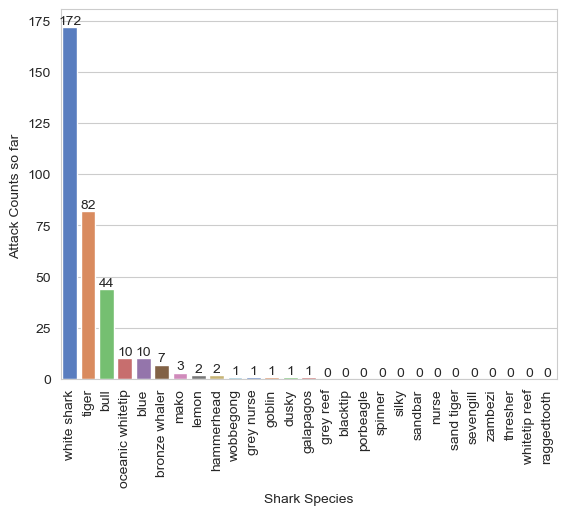

In [497]:
barFromDict(fatalitiesDict,['unknown'])

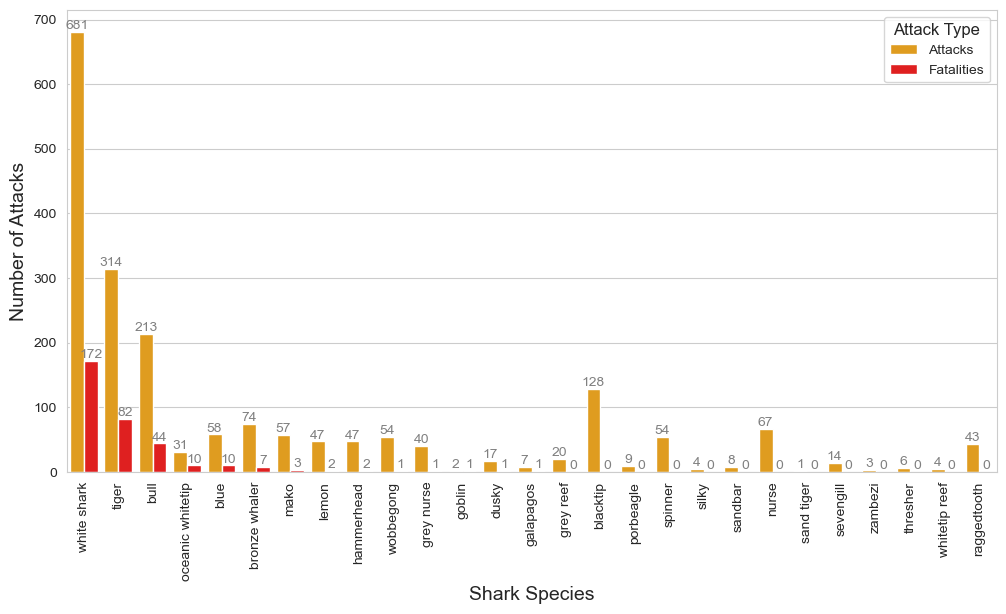

In [514]:
attacksDict = newDict
overlayBar(attacksDict,fatalitiesDict)


,CaseNumber,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,SharkSpecies
2392,2023.03.19,2023-03-19,2023.0,Unprovoked,USA,Hawaii,Anaehoomalu Bay,Swimming,male,M,60,Left hand and left leg.,N,12h30,NaN,unknown
1652,2023.03.16,2023-03-16,2023.0,Unprovoked,AUSTRALIA,Western Australia,Cheynes Beach,Surf-sking,female,F,NaN,NaN,N,08h00,5m to 6m shark,unknown
5079,2023.03.08,2023-03-06,2023.0,Unprovoked,BRAZIL,Pernambuco,Piedade Beach,Swimming,Kaylane Timóteo Freitas,F,15,Left arm severly injured,N,14h20,NaN,unknown
0,2023.03.05,2023-03-05,2023.0,Unprovoked,BRAZIL,Pernambuco,Piedade Beach,Swimming,male,M,14,Right thigh bitten resulting in surgical amput...,N,NaN,NaN,unknown
1,2023.03.02,2023-03-02,2023.0,Unprovoked,SEYCHELLES,Praslin Island,NaN,Snorkeling,Arthur …,M,6,Left foot bitten,Y,Afternoon,Lemon shark,lemon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,1742.12.17,1733-01-01,1733.0,Invalid,ICELAND,Bardestrand,Talkknefiord,NaN,NaN,NaN,NaN,"Partial hominid remains recovered from shark, ...",Y,NaN,Shark involvement prior to death unconfirmed,unknown
1641,1738.04.06.R,1723-01-01,1723.0,Unprovoked,ROATAN,NaN,NaN,NaN,Philip Ashton,M,NaN,Struck on thigh,Y,NaN,NaN,unknown
1162,1733.00.00,1721-06-01,1721.0,Unprovoked,ITALY,Sardinia,"Ponte della Maddelena,",Swimming,male,M,NaN,"FATAL, partial remains recovered from shark’s...",Y,NaN,"White shark, 1600-lb female",white shark
2157,1703.03.26,1703-03-26,1700.0,Unprovoked,FRANCE,Côte d'Azur,Antibes,Bathing,seaman,M,NaN,Leg severed,N,NaN,White shark,white shark


In [527]:
#I need a dataframe of just counts to calculate propbabilities
#yaxis will be shark
#x's will be attackcount fatality count attack probability fatality probability
#attack probability is number of attacks from shark x / total number of attacks = 6604
#fatality probability is probability of attack * probability of death  = fatality count/attackcount of that shark

probabilitiesDF=probabilityDF(attacksDict,fatalitiesDict)

In [528]:
probabilitiesDF

,SharkSpecies,Attacks,Fatalities,AttackProbability,FatalityRatio,FatalityProbability
1,white shark,681,172,0.339990,0.252570,0.085871
2,tiger,314,82,0.156765,0.261146,0.040939
3,bull,213,44,0.106340,0.206573,0.021967
4,oceanic whitetip,31,10,0.015477,0.322581,0.004993
5,blue,58,10,0.028957,0.172414,0.004993
6,bronze whaler,74,7,0.036945,0.094595,0.003495
7,mako,57,3,0.028457,0.052632,0.001498
8,lemon,47,2,0.023465,0.042553,0.000999
9,hammerhead,47,2,0.023465,0.042553,0.000999
10,wobbegong,54,1,0.026960,0.018519,0.000499


In [529]:
##LetsAddTemperaturePref in here
probabilitiesDF.to_csv("SharkStats.csv", index=False)

In [530]:
sharkStatsDF = pd.read_csv("SharkStats.csv")

In [531]:
sharkStatsDF

,SharkSpecies,Attacks,Fatalities,AttackProbability,FatalityRatio,FatalityProbability,TempLo,TempHi,AverageSize ft
0,white shark,681,172,0.339990,0.252570,0.085871,12,24,15.0
1,tiger Shark,314,82,0.156765,0.261146,0.040939,20,30,12.0
2,bull,213,44,0.106340,0.206573,0.021967,22,30,9.0
3,oceanic whitetip,31,10,0.015477,0.322581,0.004993,20,28,9.0
4,blue,58,10,0.028957,0.172414,0.004993,7,16,8.0
5,bronze whaler,74,7,0.036945,0.094595,0.003495,16,24,8.5
6,mako,57,3,0.028457,0.052632,0.001498,16,22,9.0
7,lemon,47,2,0.023465,0.042553,0.000999,20,28,8.5
8,hammerhead,47,2,0.023465,0.042553,0.000999,20,30,12.0
9,wobbegong,54,1,0.026960,0.018519,0.000499,15,30,7.0


In [533]:
dfAttacks.to_csv("SharkWrangler1.csv", index=False)
sharkStatsDF.to_csv("SharkStats.csv", index=False)